## 1. 特征处理

目标
* 体验用sns处理特征
* 体验单变量处理过程
* 体验用stcaking
* 应该先处理train发现关系
* 然后统一处理data,再分离出train_x,test_x

In [1]:
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np  # foundational package for scientific computing
import re           # Regular expression operations
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
%matplotlib inline
import seaborn as sns

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest 

#### 机器学习库

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)

from sklearn.cross_validation import KFold
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

F:\app\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# Load in the train and test datasets
train = pd.read_csv('input/train.csv')
test_x = pd.read_csv('input/test.csv')
train_x=train.drop('Survived',axis=1)
# Store our passenger ID for easy access
res = test_x['PassengerId']
train_y=train.Survived
data=pd.concat([train_x,test_x],axis=0)
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


* train 用来分析，包含 x,y
* test_x 用来预测 包含x
* train_y 是label
* data 是train_x和test_x的集合
* res 是预测结果的标签

## deal with data maybe foolish

In [5]:
head_data=data.head(2)
objects=head_data.describe(include='object').columns
numbers=np.array(list(set(head_data.columns.values)-set(objects)))

In [6]:
data.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [7]:
data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


* 分析train内与label的关系
* 训练集和测试机没有重合的passengerId

**<font color=red>我们看大概有以下这些字段</font>**<br>
PassengerId => 乘客ID<br>
Pclass => 乘客等级(1/2/3等舱位)<br>
Name => 乘客姓名<br>
Sex => 性别<br>
Age => 年龄<br>
SibSp => 堂兄弟/妹个数<br>
Parch => 父母与小孩个数<br>
Ticket => 船票信息<br>
Fare => 票价<br>
Cabin => 客舱<br>
Embarked => 登船港口

In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 只有年龄有缺失
* PassengerId,
* 38的人存活


In [10]:
objects=train.head().describe(include='object').columns.values
numbers=np.array(list(set(train.head().columns)-set(objects))).astype('object')
train.describe(include='object')


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Goncalves, Mr. Manuel Estanslas",male,347082,G6,S
freq,1,577,7,4,644


In [11]:
numbers,objects

(array(['PassengerId', 'Parch', 'Fare', 'Age', 'SibSp', 'Pclass',
        'Survived'], dtype=object),
 array(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype=object))

* cabin和Embarked有缺失，不过embarked 缺失很少

In [12]:
train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

## 分布

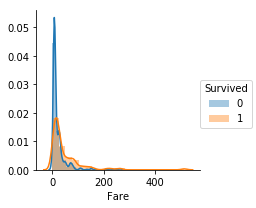

In [14]:
a=sns.FacetGrid(train,hue='Survived')
a.map(sns.distplot,'Fare',bins=20)
a.add_legend()

In [15]:
def separate_survived(name):
    a=sns.barplot(x=name,y='Survived',data=train)
    plt.show()

## 1. 处理性别
* barplot 可以看出来

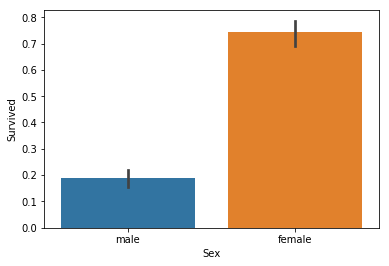

In [16]:
separate_survived('Sex')

## 2. 处理头衔
处理结果保存在 Title

## 只有一个没有头衔

In [17]:
compiles=re.compile(r'(M[A-Za-z]*)\.')
train['Title']=train.Name.apply(lambda x :re.findall(compiles,x)[0] if len(re.findall(compiles,x))==1 else 'Mr')

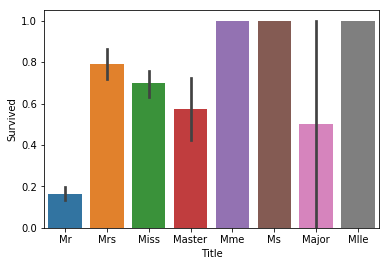

In [18]:
separate_survived('Title')

In [19]:
test_x['Title']=test_x.Name.apply(lambda x :re.findall(compiles,x)[0] if len(re.findall(compiles,x))==1 else 'Mr')

In [20]:
test_x.Title.value_counts()

Mr        246
Miss       78
Mrs        72
Master     21
Ms          1
Name: Title, dtype: int64

In [22]:
train.Title.value_counts()

Mr        538
Miss      182
Mrs       125
Master     40
Major       2
Mlle        2
Ms          1
Mme         1
Name: Title, dtype: int64

* train内的类别有些很少，应该合并为一个Rare

In [23]:
objects

array(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype=object)

## cabin

In [25]:
train['Cabin1']=train.Cabin.apply(lambda x:str(x)[0])

In [26]:
train.Cabin1.unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

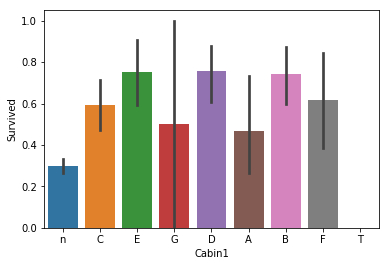

In [27]:
separate_survived('Cabin1')

In [28]:
train.Survived.groupby(train['Cabin1']).mean()

Cabin1
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64

* 有仓位号的都大于平均值
* 有时候看平均值可能会受到样本较少的影响
* 还应该看样本的个数

## 4. Embarked 确实值很少，用众数填充

In [30]:
mode=train.Embarked.value_counts().sort_values(ascending=False).index[0]
train.Embarked=train.Embarked.fillna(mode)

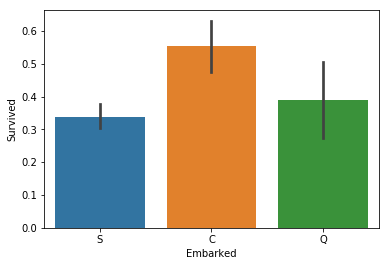

In [31]:
separate_survived('Embarked')

In [32]:
train.Survived.groupby(train['Embarked']).mean()

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

* S低于平均值
* Q等于
* C大于

In [33]:
def numbers_sns(name):
    a=sns.FacetGrid(train,hue='Survived')
    a.map(sns.distplot,name)
    a.add_legend()
    plt.show()

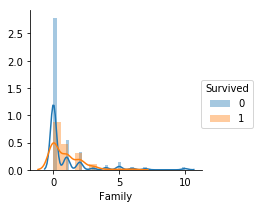

In [34]:
train['Family']=train.SibSp+train.Parch
numbers_sns('Family')


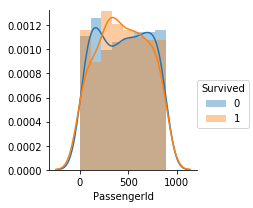

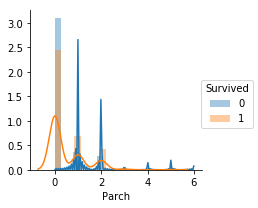

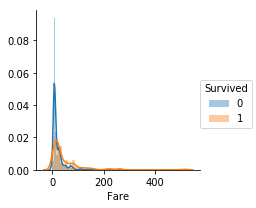

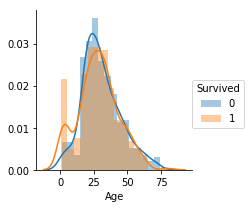

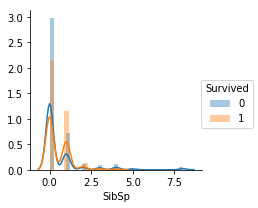

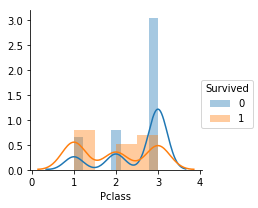

F:\app\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
F:\app\anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
F:\app\anaconda\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


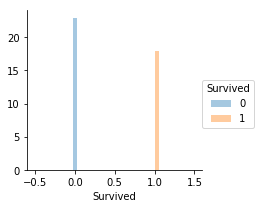

In [35]:
for i in numbers:
    numbers_sns(i)

## 三因素分析

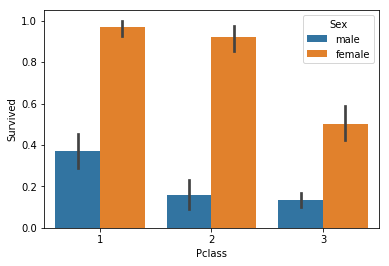

In [36]:
sns.barplot(y='Survived',x='Pclass',hue='Sex',data=train)

## test

In [37]:
test_x.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [38]:
test_x.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked,Title
count,418,418,418,91,418,418
unique,418,2,363,76,3,5
top,"Zakarian, Mr. Ortin",male,PC 17608,B57 B59 B63 B66,S,Mr
freq,1,266,5,3,270,246


* 只有年龄和cabin有缺失

### 分布

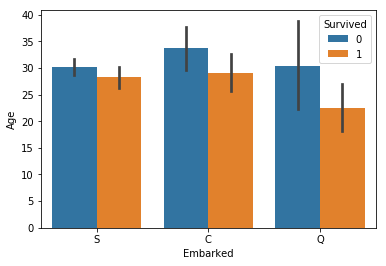

In [39]:
sns.barplot(x='Embarked',y='Age',data=train,hue='Survived')

In [40]:
train_y.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

* along to columns 就是横着
* along to row 就是竖着

In [41]:
age=preprocessing.Imputer(strategy='median',axis=1)
a=np.array(np.arange(10)).astype(np.float64)
a=a.reshape(2,5)
a[0,0]=np.nan
age.fit_transform(a)

array([[2.5, 1. , 2. , 3. , 4. ],
       [5. , 6. , 7. , 8. , 9. ]])

In [43]:
age=preprocessing.Imputer(strategy='median',axis=0)
a=np.array(np.arange(10)).astype(np.float64)
a=a.reshape(2,5)
a[0,0]=np.nan
age.fit_transform(a)


array([[5., 1., 2., 3., 4.],
       [5., 6., 7., 8., 9.]])

In [44]:
age=preprocessing.Imputer(strategy='median',axis=0)

In [45]:
age.fit(data.Age.values.reshape(-1,1))
train['Age2']=age.transform(train['Age'].values.reshape(-1,1))

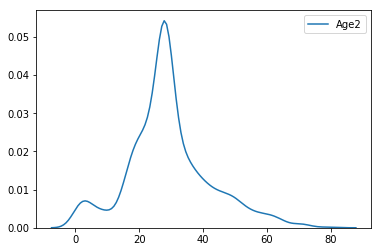

In [46]:
sns.kdeplot(train['Age2'],)

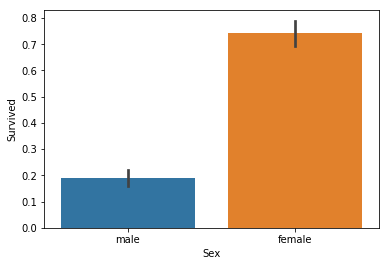

In [47]:
sns.barplot(x='Sex',y='Survived',data=train)

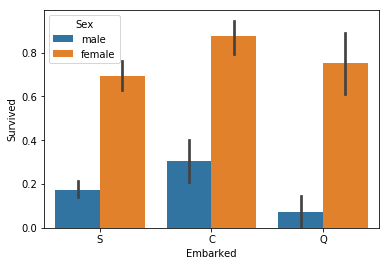

In [48]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train)

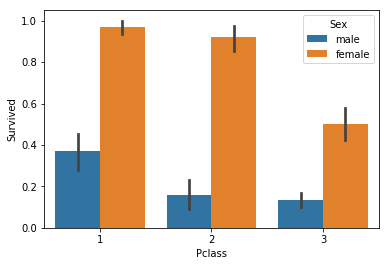

In [49]:
sns.barplot(x='Pclass',y='Survived',hue='Sex',data=train)

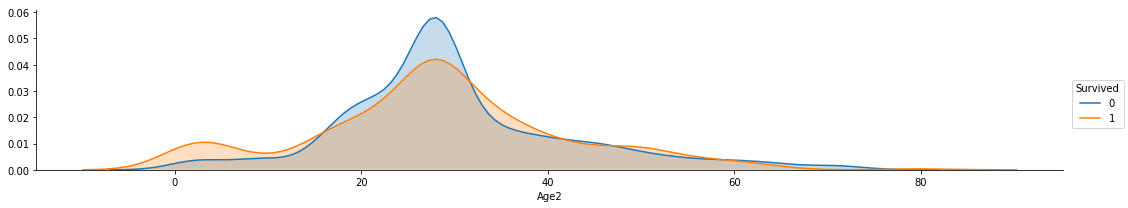

In [51]:
a=sns.FacetGrid(train,hue='Survived',aspect=5)
a.map(sns.kdeplot,'Age2',shade=True)
a.add_legend()


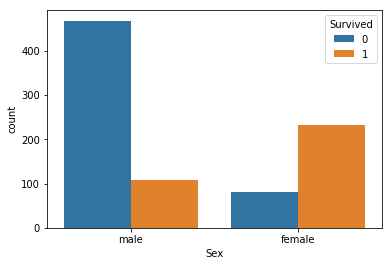

In [52]:
sns.countplot('Sex',hue='Survived',data=train,)

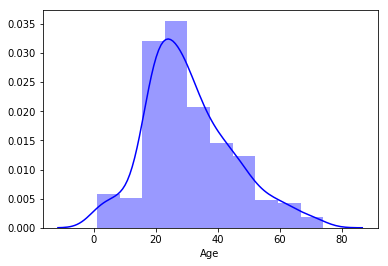

In [53]:
sns.distplot(train[train['Survived']==0]['Age'].dropna(),kde=True,color='b',bins=10)

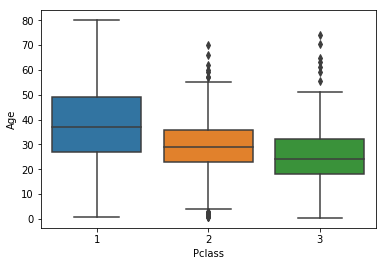

In [54]:
sns.boxplot(x='Pclass',y='Age',data=train)

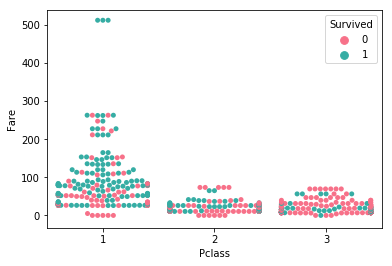

In [55]:
sns.swarmplot(x='Pclass',y='Fare',hue='Survived',data=train,palette='husl',)

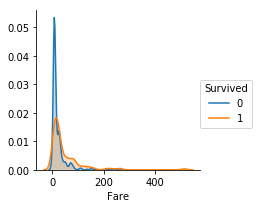

In [56]:
a=sns.FacetGrid(train,hue='Survived')
a.map(sns.kdeplot,'Fare',shade=True)
a.add_legend()

F:\app\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
F:\app\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


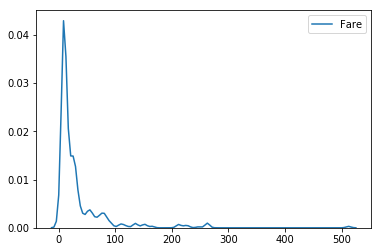

In [57]:
sns.kdeplot(data.Fare)